In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.feature_extraction.text import TfidfVectorizer
# From https://scikit-learn.org/stable/modules/feature_extraction.html

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import joblib
import spacy
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\loic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\loic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## To analyse the text of the reviews, we will need to lemmatize the text. Lemmatization is the act of grouping words from the same root (play, played, playing for example)

### We use two common Lemmatizer: ***WordNet*** and ***SpaCy***. We will look at their result later to find which one performs the best.

### We also define a list of stop words. We use the default stopwords from nltk, and we have incrementaly added a list of stopwords found during EDA.

In [3]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

supp_stopwords = ['-PRON-','-pron-','go', 'shall', 'thank','win', 'definitely','without','le', 'stuff', 'thanks', 'overall', 'going', 'end', 'something', 'actually', 'pretty', 'smell', 'right', 'almost', 'e', 'le', 'u', 'come', 'gleincairn', 'take', 'buy', 'however', 'let', 'end', 'two', 'one','first', 'ex', 'comment', 'thanks','could', 'might', 'must', "n't", 'need', 'r', 'sha', 'v', 'wo', 'would', 'com', 'abc', 'abv', 'jpg', 'got', 'may', 'way', 'get', 'look', 'see', 'www', 'http', 'https', 'yet', 'whiskey', 'whisky', 'reddit', 'review', 'year', 'bottle', 'note', 'taste', 'nbsp', 'made', 'say', 'rather', 'maybe', 'cask', 'really', 'malt', 'single', 'score', 'think', 'find', 'thing', 'little', 'lot', 'sample', 'amp', 'rating', 'price', 'dram', 'distillery', 'time', 'well', 'nice', 'try', 'quite', 'much', 'like', 'hint', 'bit', 'now', 'color', 'bottled', 'flavor', 'make', 'also', 'imgur', 'finish', 'nose', 'add', "'", "'d", "'s", "'ll", "'re", "'ve", 'unless', 'follow', 'key', 'link', 'website', 'tag', 'hello', 'image', 'wordpress', 'hi', 'oz', 'ml'] + list(string.ascii_lowercase)

stem_stopwords = stopwords.words('english') + supp_stopwords
stem_stopwords_WordNet = [lemmatizer.lemmatize(word) for word in stem_stopwords]
stem_stopwords_Spacy = [nlp(stopword) for stopword in stem_stopwords]
stem_stopwords = set(stem_stopwords)

class LemmaTokenizerWordNet:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

class LemmaTokenizerSpacy:
    def __init__(self):
        self.nwl = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        self.nwl.Defaults.stop_words |= stem_stopwords #Allows the use of the custom stopwords with SpaCy
    def __call__(self, doc):
        return [token.lemma_ for token in self.nwl(" ".join(doc.split())) if not token.is_stop]

def do_nothing():
    pass

def convert_float_na(x):
    try:
        return float(x)
    except:
        return np.nan

# 1. Data Cleaning and Exploratory Data Analysis

## We start by loading the data from the archive, which is simply a .csv file downloaded from google drive, and the extracted reviews and merging the two together.

### (The reviews where extracted using ```extract_reddit.py``` - This script run for a long time, about one hour on a Ryzen 5600X, and put some load on the reddit website, so the results were saved so the script need to be runned only once)

### The idea of the script is simply to use a webscrapper to extract either the main post of the reddit thread, or the first comment (some reviews use the main post to post only an image, and the review is in the first comment). So if the main post doesn't contain text, we used the first comment, otherwise we simply took the main post.

In [4]:
df_reddit_raw = pd.read_csv('dataset/Reddit Whisky Network Review Archive - Review Archive.csv')

In [5]:
df_reddit_raw.sample(10)

,Timestamp,Whisky Name,Reviewer's Reddit Username,Link To Reddit Review,Reviewer Rating,Whisky Region or Style,Full Bottle Price Paid,Date of Review
20319,2/15/2017 14:14:10,High West Bourye,razzafrachen,https://www.reddit.com/r/bourbon/comments/5u9x...,88,America,NaN,2/15/17
19373,7/24/2013 8:38:11,Glenrothes 1998,Allumina,http://www.reddit.com/r/Scotch/comments/1iydgi...,85,Speyside,60,7/24/2013
27224,10/11/2013 21:25:44,Macallan 12 Sherry,baudtack,http://www.reddit.com/r/Scotch/comments/1o9kyt...,80,Speyside,NaN,10/11/2013
29523,9/23/2013 12:02:29,Old Grand Dad 100 Bottled in Bond,reddbdb,http://www.reddit.com/r/bourbon/comments/1myri...,77,Bourbon,17,9/23/2013
36872,NaN,Caol Ila 34 1982 Cadenhead's Small Batch,Herr_Maltenberg,https://www.reddit.com/r/Scotch/comments/k45uj...,92,Islay,NaN,11/30/20
25529,5/28/2017 21:00:11,Laphroaig Cairdeas 2013 Portwood,unbreakablesausage,https://www.reddit.com/r/Scotch/comments/67dot...,90,Islay,NaN,04/25/17
8452,1/6/2014 22:36:05,Bruichladdich The Laddie Ten,mentel42,http://www.reddit.com/r/Scotch/comments/1ullh8...,83,Islay,40,1/6/2014
18582,7/17/2014 19:55:09,Glenlossie 10 Flora & Fauna,ComputerGeek485,http://www.reddit.com/r/Scotch/comments/2aj2lc...,78,Speyside,NaN,6/15/2014
21027,5/3/2014 9:45:28,Highland Park 18,Sinjun86,http://www.reddit.com/r/Scotch/comments/20f2km...,91,Islands,NaN,3/14/2014
7652,1/29/2020 20:19:05,Bruichladdich Octomore 10.3,LIFOanAccountant,https://old.reddit.com/r/Scotch/comments/evxwq...,60,Islay,NaN,1/29/20


In [6]:
with open("dataset/review_results.txt", 'r') as f:
    raw_data = json.load(f)

## Some reviews are there twice, so we drop duplicated using the column ```Link To Reddit Review```

In [7]:
df_data = pd.concat([df_reddit_raw, pd.Series(raw_data, name='Review')], axis=1)

df_data.drop_duplicates(subset=['Link To Reddit Review'], inplace=True)
df_data.reset_index(inplace=True, drop=True)

In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32053 entries, 0 to 32052
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Timestamp                   28353 non-null  object
 1   Whisky Name                 32053 non-null  object
 2   Reviewer's Reddit Username  32053 non-null  object
 3   Link To Reddit Review       32052 non-null  object
 4   Reviewer Rating             31829 non-null  object
 5   Whisky Region or Style      32053 non-null  object
 6   Full Bottle Price Paid      12286 non-null  object
 7   Date of Review              32053 non-null  object
 8   Review                      32053 non-null  object
dtypes: object(9)
memory usage: 2.2+ MB


## Then we drop the ```Timestamp```, ```Link To Reddit Reviews``` and ```Date of Review``` since they are not that meaningfull for further analysis.
## We also drop ```Full Bottle Price Paid``` because it is missing too much value, and eitherway the bottle price are fluctuating a lot, and depends on the region.

In [9]:
df_data.drop(['Timestamp', 'Link To Reddit Review', 'Full Bottle Price Paid', 'Date of Review'], axis=1, inplace=True)
df_data.rename(columns={'Reviewer\'s Reddit Username': 'Reddit Username', 'Whisky Name':'Whiskey Name','Reviewer Rating': 'Score', 'Whisky Region or Style':'Whiskey Type'}, inplace=True)

df_data['Whiskey Name'] = df_data['Whiskey Name'].str.strip().str.lower()

In [10]:
df_data.dropna(inplace=True)

In [11]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31829 entries, 0 to 32052
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Whiskey Name     31829 non-null  object
 1   Reddit Username  31829 non-null  object
 2   Score            31829 non-null  object
 3   Whiskey Type     31829 non-null  object
 4   Review           31829 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [12]:
df_data.describe()

,Whiskey Name,Reddit Username,Score,Whiskey Type,Review
count,31829,31829,31829,31829,31829
unique,10649,1818,111,82,30654
top,ardbeg 10,TOModera,85,Speyside,[effacé]
freq,173,1562,2516,6078,710


# After cleaning we have 31829 unique reviews

## We will now clean the ```Whiskey Type``` column. As it can be seen below there is quite a few whiskey type that are spelled in multiple different way. We also regroup the less common category into their sup-category (like Washington being replace by america)

## We also regroup the types with less than 35 whiskeys into an 'other' category

In [29]:
df_data['Whiskey Type'] = df_data['Whiskey Type'].str.strip().str.lower()
df_data['Score'] = df_data['Score'].apply(lambda x: convert_float_na(x))
df_data['Review'] = df_data['Review'].str.replace(r'([^A-Za-z\s])', ' ', regex=True).str.lower().str.strip()

dict_replace = {'lowland': 'lowlands',
                'lowland grains': 'lowlands',
                'ireland': 'irish',
                'lowland grain': 'lowlands',
                'highland' : 'highlands',
                'wheat whiskey': 'wheat',
                'tennessee': 'america',
                'american single malt': 'america',
                'isle of jura': 'islay',
                'usa / pacific northwest': 'america',
                'washington': 'america'}

for key, value in dict_replace.items():
    df_data['Whiskey Type'].replace(dict_replace, inplace=True)

replacement_key = (df_data['Whiskey Type'].value_counts() < 35)
for indx in replacement_key.index:
    if replacement_key[indx]:
        df_data['Whiskey Type'].replace(indx, 'other', inplace=True)

In [30]:
df_data.head()

,Whiskey Name,Reddit Username,Score,Whiskey Type,Review
0,100 pipers,merlinblack,68.0,blend,my wife and i are on a trip to thailand to mee...
1,1792 12 year,atxbourbon,70.0,bourbon,i m still a fan of even though my initial...
2,1792 225th anniversary,scottmotorrad,80.0,bourbon,the series continues and this time we are...
3,1792 225th anniversary,WildOscar66,80.0,bourbon,bourbon review th anniversary sa...
4,1792 bottled in bond,scottmotorrad,80.0,bourbon,the review series continues the bottled ...


## Before extracting the key words of the description using TF-IDF lets look at the distribution of whiskey in the data and the score distribution

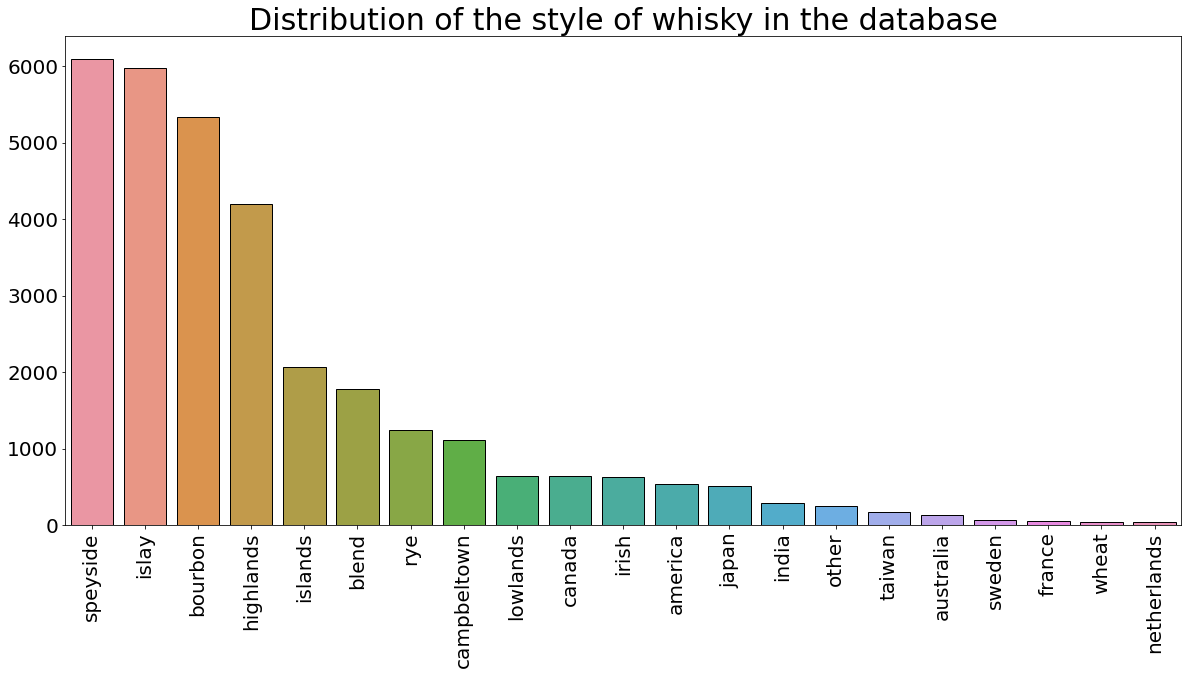

In [44]:
index = df_data['Whiskey Type'].value_counts().index
values =  df_data['Whiskey Type'].value_counts().values

fig, ax = plt.subplots(figsize=(20,9))
sns.barplot(x=index, y=values, ax=ax, edgecolor='k')
plt.xticks(rotation=90);
ax.set_title('Distribution of the style of whisky in the database', size=30);


C:\Users\loic\anaconda3\envs\EPFL_ML_updated\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


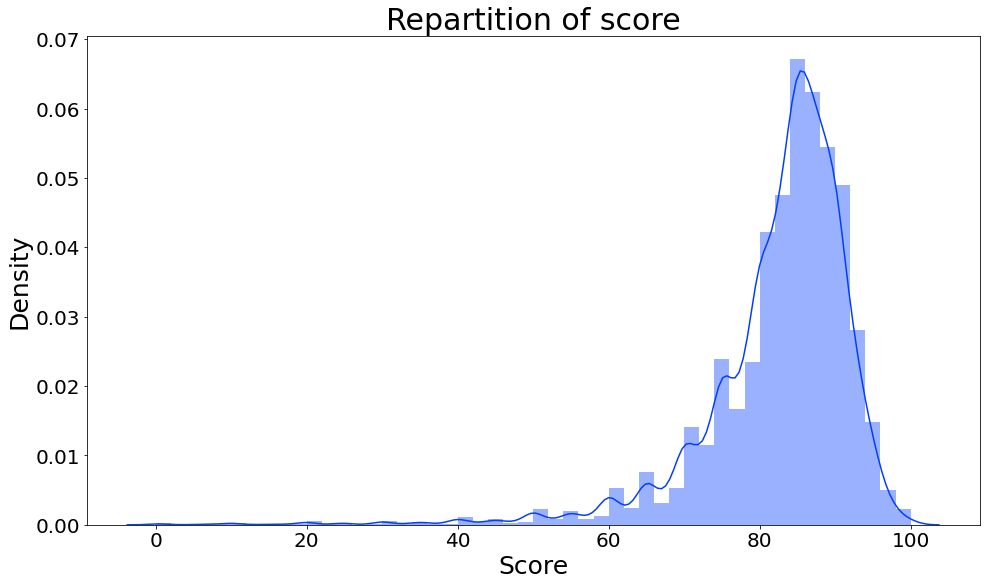

In [45]:
values = df_data['Score'].values

fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(values, ax=ax);
ax.set_xlabel('Score');
ax.set_title('Repartition of score', size=30);

## We observe a long left-tail on the scoring of the whiskey. Which make sense, since it is more probable that people will review good whiskeys over bad ones.

We will remove the left-tail, to reduce the skewness. And also, since we are planning to do a whiskey-suggestion system, removing bad whiskeys should be seen as a positive.

In [47]:
df_data.drop(df_data[df_data['Score'] < 30].index, inplace=True)

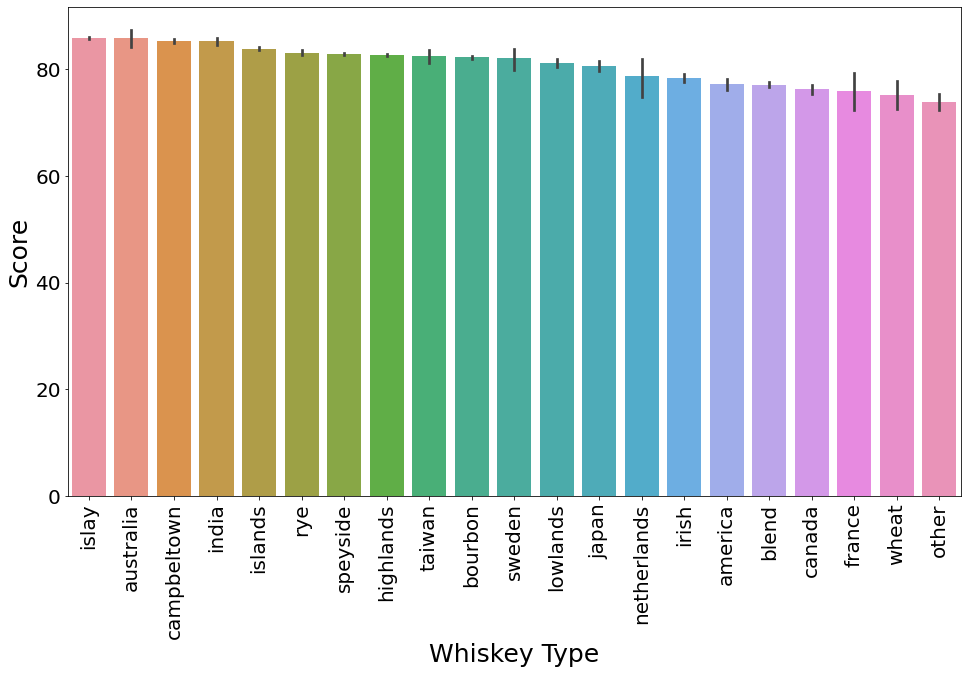

In [48]:
fig, ax = plt.subplots(figsize=(16,9))

sns.barplot(data = df_data, x = 'Whiskey Type', y='Score', order=df_data.groupby('Whiskey Type')['Score'].mean().sort_values(ascending=False).index);
plt.xticks(rotation=90);

## There is no obvious variation of score between style. We therefore need to extract more information using the reviews.


## Lets look at the user-distribution now, to see if there is some "star-player" that reviewed a lot of whiskeys.

### Similarly than for the whiskey types we will regroup the users with less than 50 reviews in an "other" category.

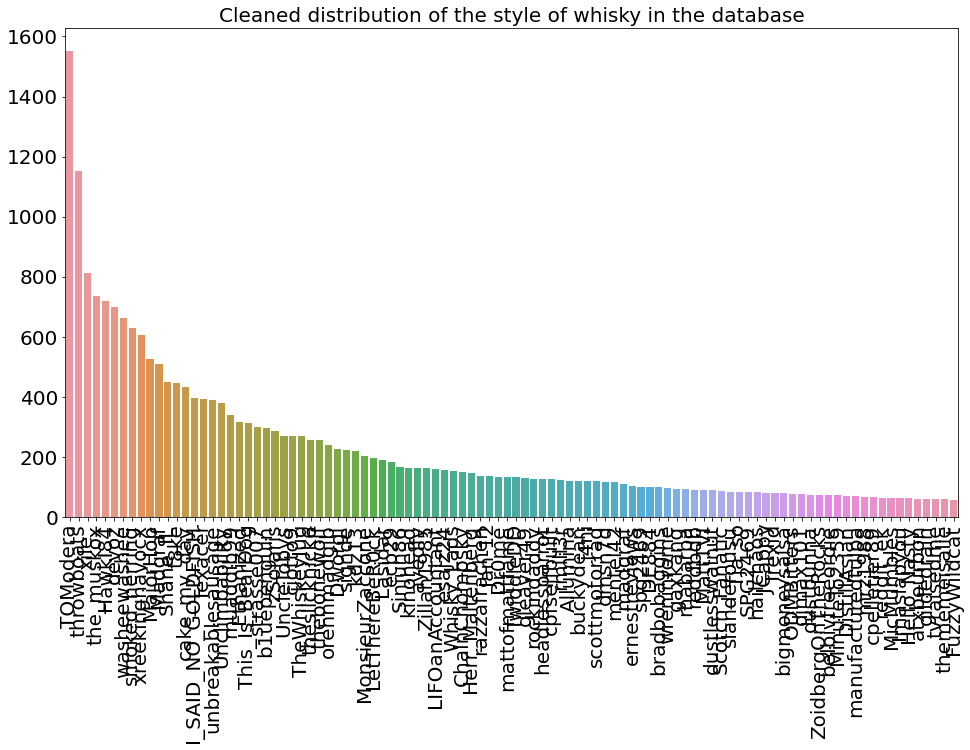

In [49]:
index = df_data['Reddit Username'].value_counts().index[:100]
values =  df_data['Reddit Username'].value_counts().values[:100]

fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(x=index, y=values, ax=ax)
plt.xticks(rotation=90);
plt.title('Cleaned distribution of the style of whisky in the database');


## As we can see, already the 100th reviewers "only" reviewed around 60 whiskeys. So we will regroup all the smaller reviewers in a category "other"

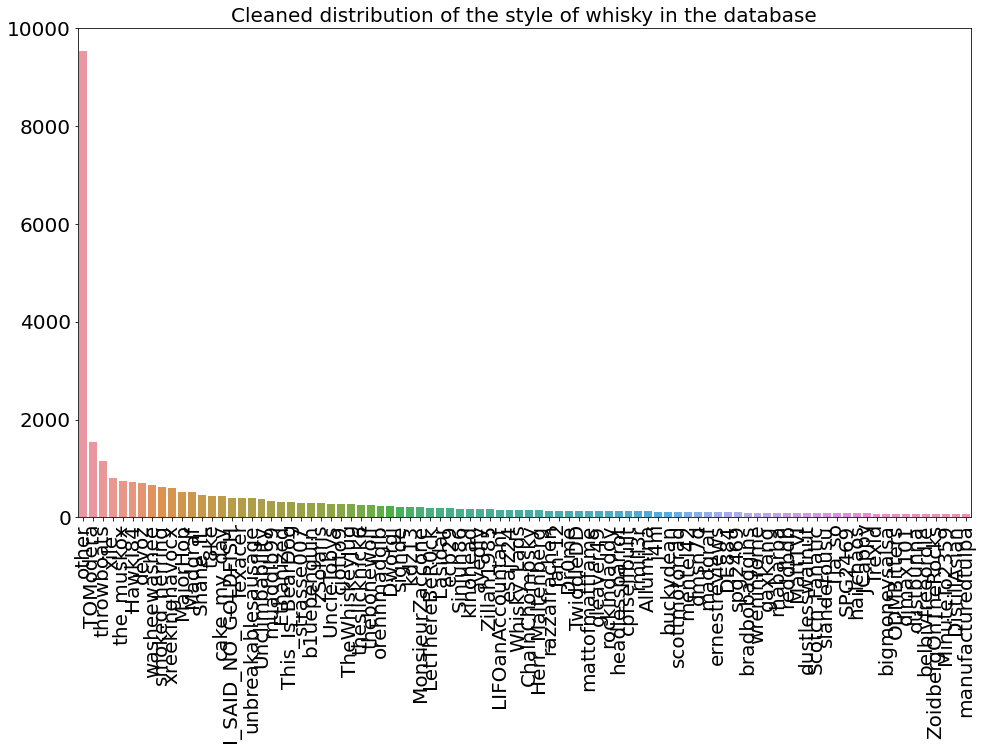

In [50]:
replacement_key = (df_data['Reddit Username'].value_counts() < 70)
for indx in replacement_key.index:
    if replacement_key[indx]:
        df_data['Reddit Username'].replace(indx, 'other', inplace=True)

index = df_data['Reddit Username'].value_counts().index
values =  df_data['Reddit Username'].value_counts().values

fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(x=index, y=values, ax=ax)
plt.xticks(rotation=90);
plt.title('Cleaned distribution of the style of whisky in the database');

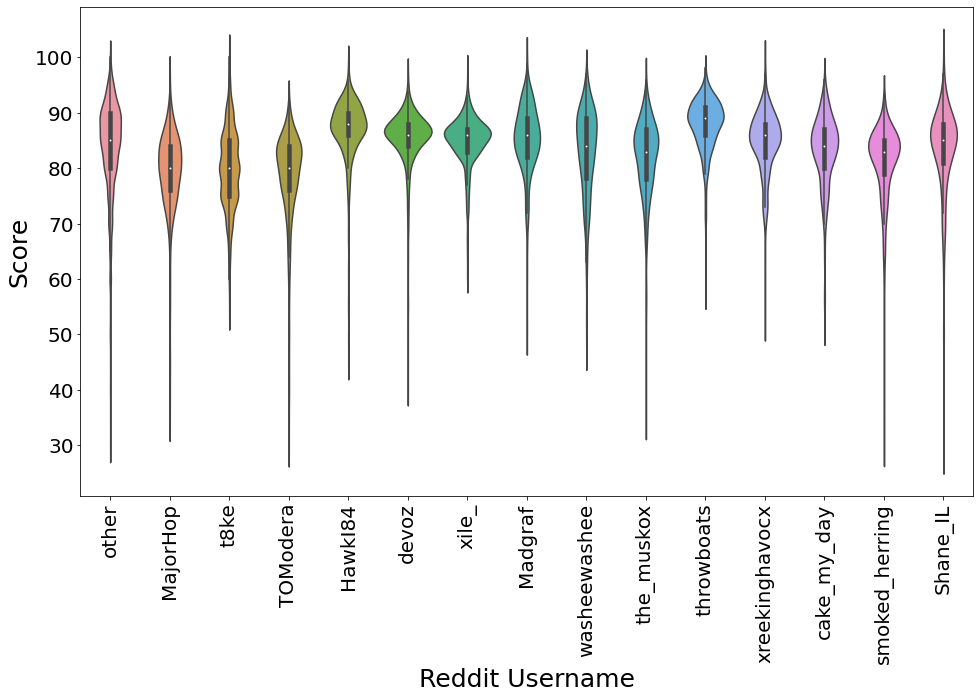

In [51]:
fig, axes = plt.subplots(1,1, figsize=(16,9))
index_topTen = df_data['Reddit Username'].isin(index[:15])

sns.violinplot(data=df_data[index_topTen], x="Reddit Username", y="Score")
plt.xticks(rotation=90);

Text(0.5, 0.98, 'Repartition of whiskey per top users')

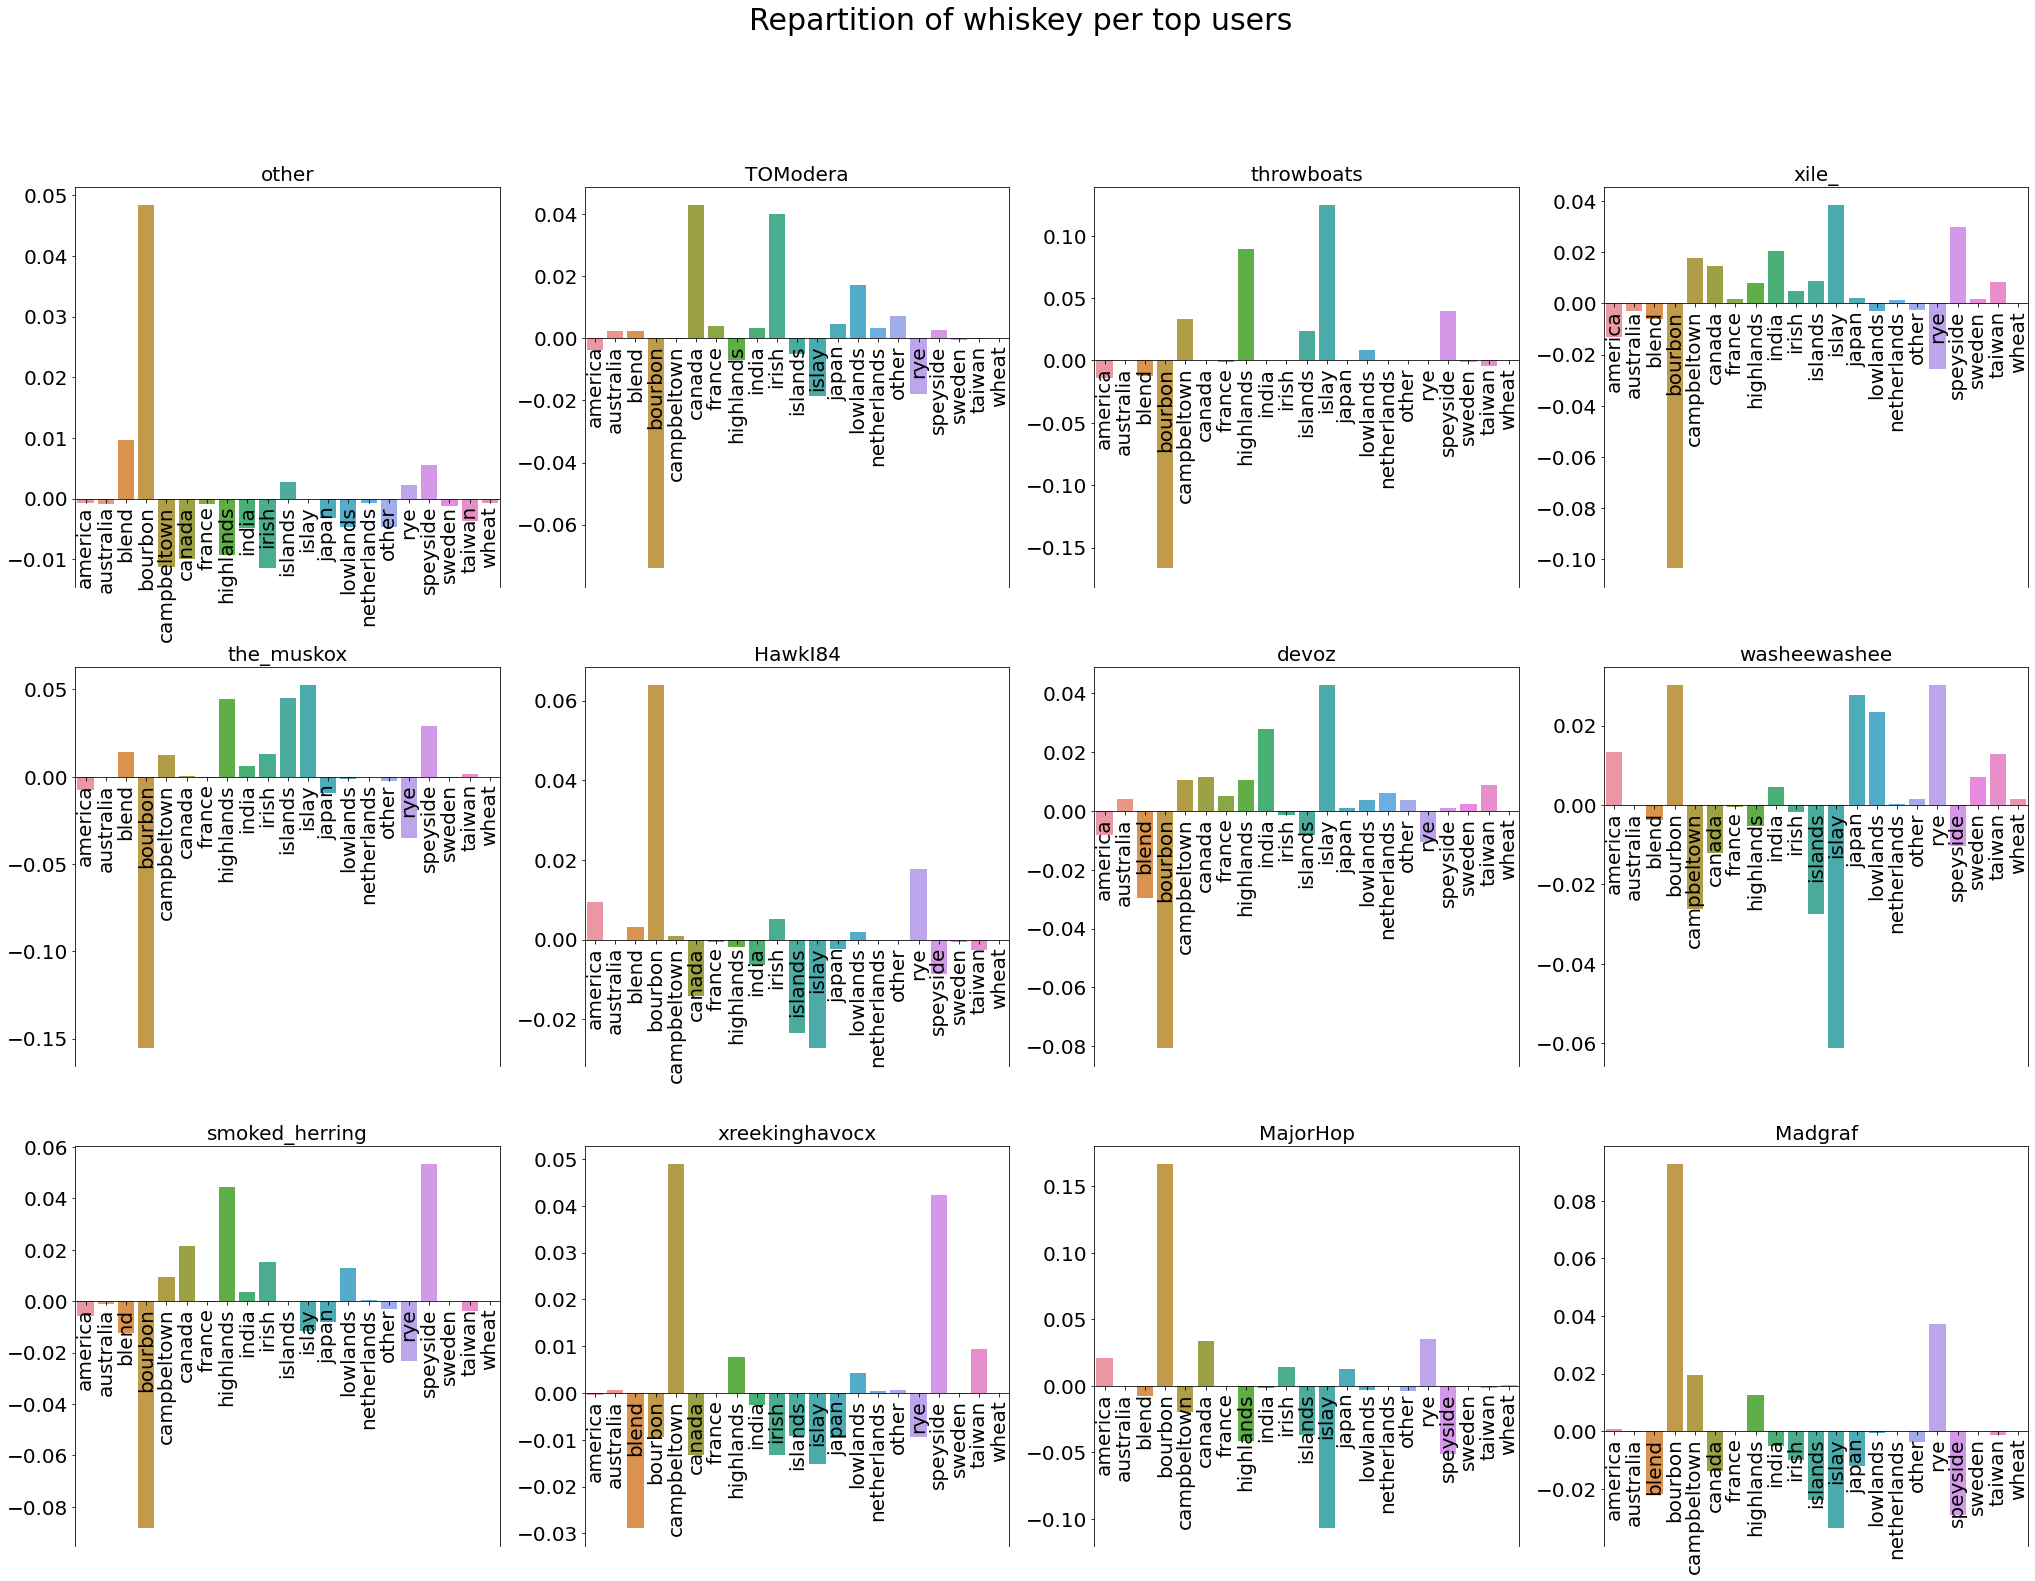

In [56]:
fig, axes = plt.subplots(3,4, figsize=(35, 25))
flat_axes = np.ravel(axes)

for i,ind in enumerate(index[0:12]):
    tmp_serie = df_data[df_data['Reddit Username'] == ind]['Whiskey Type'].value_counts()/df_data[df_data['Reddit Username'] == ind]['Whiskey Type'].value_counts().sum()
    tmp_full = df_data['Whiskey Type'].value_counts()/df_data['Whiskey Type'].value_counts().sum()
    tmp_serie.fillna(0, inplace=True)

    tmp_serie = tmp_serie - tmp_full

    sns.barplot(x=tmp_serie.index, y=tmp_serie.values, ax=flat_axes[i])
    flat_axes[i].set_title(ind)
    #plt.xticks(rotation=90);
    flat_axes[i].spines['bottom'].set_position('zero')
    flat_axes[i].set_xticklabels(tmp_serie.index, rotation=90)
fig.suptitle('Repartition of whiskey per top users', size=)

## What is interesting to note here is that the top reviewers have their favourite whiskeys. We have a few bourbons lovers that reviews a lot more bourbons that the average.
## Another interesting thing is that bourbons-enjoyer seems to taste test less Islay than the rest

## Some whiskeys appears multiple time (see above for example the '1792 225th Anniversary') So we will regroup them.

### For the categorical columns (Username and Whiskey Type) we will use one-hot encoding before merging, so if a whiskey was categorized into two categories it will have a 1 in both one-hot encoded column.

### For the score we use the median, and the reviews will be joined together to be considered as one review.

In [108]:
onehot = pd.get_dummies(df_data['Whiskey Type'], prefix='Type')

df_data = pd.concat([df_data, onehot], axis=1)
df_data.drop(['Whiskey Type'], axis=1, inplace=True)

In [109]:
onehot = pd.get_dummies(df_data['Reddit Username'], prefix='Username')

df_data = pd.concat([df_data, onehot], axis=1)
df_data.drop(['Reddit Username'], axis=1, inplace=True)

In [110]:
grouped_data = df_data.groupby('Whiskey Name')

In [111]:
dict_data = {}

for col in df_data.columns :
    if col == 'Score':
        dict_data[col] = grouped_data[col].median()
    elif col == 'Review':
        dict_data[col] = grouped_data[col].agg(lambda x: ' '.join(x))
    elif ('Type' in col) or ('Username' in col):
        dict_data[col] = grouped_data[col].max()

In [112]:
df_data = pd.DataFrame(dict_data)
df_data.reset_index(level=0, inplace=True)
df_data.dropna(inplace=True)

In [113]:
df_data.describe()

,Score,Type_america,Type_australia,Type_blend,Type_bourbon,Type_campbeltown,Type_canada,Type_france,Type_highlands,Type_india,...,Username_the_muskox,Username_thebonewolf,Username_theslicknick6,Username_throwboats,Username_unbreakablesausage,Username_washeewashee,Username_wreninrome,Username_xile_,Username_xreekinghavocx,Username_zSolaris
count,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,...,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000,10532.000000
mean,82.173258,0.023737,0.007026,0.052886,0.153152,0.033042,0.022978,0.002848,0.146316,0.007406,...,0.069597,0.023927,0.024212,0.108526,0.036935,0.062571,0.009115,0.076624,0.056969,0.026965
std,8.956096,0.152236,0.083531,0.223817,0.360151,0.178755,0.149839,0.053297,0.353440,0.085743,...,0.254479,0.152829,0.153714,0.311059,0.188611,0.242202,0.095041,0.266006,0.231795,0.161990
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,84.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Now, we will need to lemmatize our texts to find the meaningfull keyords. We will compare two common Lemmatizer: WordNet and Spacy

### Once lemmatized, we will use Tfidf to extract the relevant words from the reviews. Later, we will represent them in a wordclouds to see if the extracted words make sense.

### To do such we will use TfidfVectorizer with a Lemmatizer to regroup the different forms of a same word (taste, tasted, tasting for example). The list of stopwords was expanded recursively by manual identification



In [114]:
review_text = df_data['Review']

### The cell bellow (commented) was the one used to fit the two lemmatizer. Since the fitting time was long, the fitted models were saved using joblib, and are loaded when necessary.

In [115]:
'''
count_vect_WordNet = TfidfVectorizer(stop_words=stem_stopwords_WordNet, max_df=1.0,min_df=0.05, tokenizer=LemmaTokenizerWordNet())

with joblib.parallel_backend('threading', n_jobs=-1):
    raw_data_stemmed_WordNet = count_vect_WordNet.fit(review_text)
    joblib.dump(count_vect_WordNet, 'models/test_Lemma/WordNet.joblib')


count_vect_Spacy = TfidfVectorizer(stop_words=stem_stopwords_Spacy, max_df=1.0,min_df=0.05, tokenizer=LemmaTokenizerSpacy())
with joblib.parallel_backend('loky', n_jobs=-1):
    raw_data_stemmed_Spacy = count_vect_Spacy.fit(review_text)
    joblib.dump(count_vect_Spacy, 'models/test_Lemma/Spacy.joblib')
''';

In [58]:
count_vect_Spacy = joblib.load('models/test_Lemma/Spacy.joblib')
count_vect_WordNet = joblib.load('models/test_Lemma/WordNet.joblib')

In [59]:
df_frequency_Wordnet = pd.DataFrame({'Vocabulary': count_vect_WordNet.get_feature_names_out(), 'Inverse Document Frequency WordNet':count_vect_WordNet.idf_})
df_frequency_Spacy = pd.DataFrame({'Vocabulary': count_vect_Spacy.get_feature_names_out(), 'Inverse Document Frequency Spacy':count_vect_Spacy.idf_})

In [60]:
df_merged_frequency = pd.merge(
    df_frequency_Wordnet,
    df_frequency_Spacy,
    on='Vocabulary',
    how="outer")

## Now we take a look at the words present in a dictionnary and not the other.

### * The words present in the WordNet dictionnary and not in the SpaCy one, are words that should have been lemmatized, (according -> accord, added-> add, baked -> bake, ...)
### * In the contrary words in the SpaCy dictionnary not present in the WordNet ones seems to be unique words, even though not necessarily relevant. But this is an issue that will be partially fixed by using a higher value of min_df and could be improved further by using better stopwords

In [66]:
df_merged_frequency[df_merged_frequency['Inverse Document Frequency Spacy'].isnull()].sort_values('Inverse Document Frequency WordNet').head(20)

,Vocabulary,Inverse Document Frequency WordNet,Inverse Document Frequency Spacy
74,better,1.877442,NaN
233,distilled,2.112564,NaN
6,added,2.265726,NaN
926,tried,2.328661,NaN
523,matured,2.336062,NaN
73,best,2.396200,NaN
318,filtered,2.439969,NaN
243,dried,2.473492,NaN
490,lingering,2.480006,NaN
334,found,2.493993,NaN


In [67]:
df_merged_frequency[df_merged_frequency['Inverse Document Frequency WordNet'].isnull()].sort_values('Inverse Document Frequency Spacy').head(20)

,Vocabulary,Inverse Document Frequency WordNet,Inverse Document Frequency Spacy
1176,nose,NaN,1.024284
1007,a,NaN,1.024855
1097,finish,NaN,1.025237
1022,and,NaN,1.032511
1259,the,NaN,1.034338
1033,be,NaN,1.040903
1183,of,NaN,1.049367
1006,I,NaN,1.054558
1267,this,NaN,1.057213
1273,to,NaN,1.071593


In [144]:
check_stopwords = df_merged_frequency[df_merged_frequency['Inverse Document Frequency WordNet'].isnull()].sort_values('Inverse Document Frequency Spacy')

list_stopwords = [word.text for word in stem_stopwords_Spacy]
word_lst = []
value_lst = {}

for i,line in check_stopwords.iterrows():
    word = line['Vocabulary'].lower()
    value = line['Inverse Document Frequency Spacy']
    if word in list_stopwords:
        word_lst.append(word)
        value_lst[word] = value

In [145]:
max(value_lst)

value_lst = {key:np.abs(value_lst[key] - value_lst['z']) + 1 for key in value_lst.keys()}

In [146]:
value_lst

{'nose': 3.701971155025828,
 'a': 3.701399345232301,
 'finish': 3.701017956974436,
 'and': 3.693743805450972,
 'the': 3.6919169696946046,
 'be': 3.685351338307548,
 'of': 3.676887841121637,
 'i': 1.7348778530164184,
 'this': 3.669041586666527,
 'to': 3.6546614112614417,
 'in': 3.6367209986221143,
 'it': 3.633767388489961,
 'for': 3.6051067955487373,
 'but': 3.597626383487837,
 'with': 3.594873019469461,
 'have': 3.542965594476114,
 'that': 3.539609135742109,
 's': 3.516022601796079,
 'not': 3.4984275188681497,
 'abv': 3.4882155632301473,
 'review': 3.4812303930535338,
 'on': 3.4789705050860964,
 'bottle': 3.4756308073254787,
 'at': 3.470960419816867,
 'some': 3.4591273911403837,
 't': 3.43366319466882,
 'year': 3.4334139734837295,
 'note': 3.4291676826022783,
 'from': 3.41707990006475,
 'taste': 3.415685464901866,
 'more': 3.403946144172816,
 'my': 3.4031757281100568,
 'as': 3.392327113381208,
 'very': 3.388684596019623,
 'like': 3.3753020819452644,
 'one': 3.3527271567880588,
 'cask':

Text(0.5, 1.0, 'Common Stopwords')

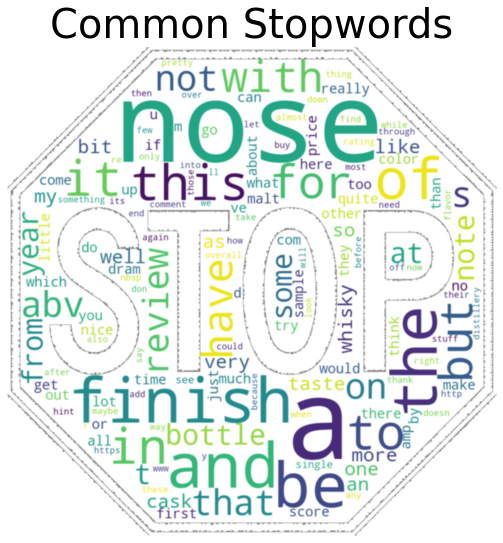

In [147]:
from wordcloud import WordCloud
from PIL import Image

fig, ax = plt.subplots(1,1, figsize=(16,9))
mask = np.array(Image.open(r'D:\Knox\PhD\cours\EPFL_MachineLearning\final_project\74537_75_r1-1_b_lg.gif'))
wordcloud = WordCloud(width=1920, height=1080, max_words=150, background_color='white', mask=mask, contour_color='grey', contour_width=1).generate_from_frequencies(frequencies=value_lst)

ax.imshow(wordcloud, interpolation='bicubic')
ax.axis("off")
ax.set_title("Common Stopwords", size=40)

## We want to spend some time analysing the effect of the Tfidf parameters: ```min_df``` and ```max_df```

### * ```min_df``` is used to ignore words with document frequency smaller than the threshold, meaning that it will remove very rare words from the dictionnary
### * ```max_df``` is used to ignore words with document frequency higher than the threshold, meaning that il will remove too common words from the dictionnary

In [121]:
'''
review_text = df_data['Review']

for min_val in np.arange(0,0.15,0.01):
    count_vect = TfidfVectorizer(stop_words=stem_stopwords, max_df=1.0,min_df=min_val, tokenizer=LemmaTokenizerSpacy())
    with joblib.parallel_backend('threading', n_jobs=-1):
        count_vect.fit(review_text)
    joblib.dump(count_vect, 'models/min_df/TfIdfVectorizer_{:.2f}_min_df.joblib'.format(min_val))
''';

In [122]:
list_min_voc_lenght = []
list_min_df = []

for min_val in np.arange(0,0.15,0.01):
    count_vect = joblib.load('models/min_df/TfIdfVectorizer_{:.2f}_min_df.joblib'.format(min_val))
    list_min_df.append(min_val)
    list_min_voc_lenght.append(len(count_vect.vocabulary_))

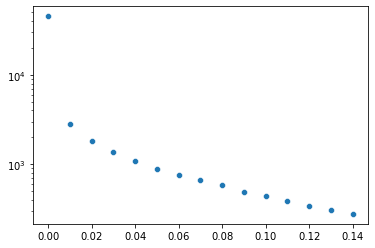

In [123]:
scatter = sns.scatterplot(x=list_min_df, y=list_min_voc_lenght)
scatter.set(yscale="log");

In [124]:
'''
review_text = df_data['Review']

for max_val in np.arange(0.1, 0.6, 0.1):
    count_vect = TfidfVectorizer(stop_words=stem_stopwords, max_df=max_val,min_df=0.00, tokenizer=LemmaTokenizerSpacy())
    with joblib.parallel_backend('threading', n_jobs=-1):
        count_vect.fit(review_text)
    joblib.dump(count_vect, 'models/max_df/TfIdfVectorizer_{:.2f}_max_df.joblib'.format(max_val))
''';

In [125]:
list_max_voc_lenght = []
list_max_df = []

for max_val in np.arange(0.1, 1.0, 0.1):
    try:
        count_vect = joblib.load('models/max_df/TfIdfVectorizer_{:.2f}_max_df.joblib'.format(max_val))
        list_max_df.append(max_val)
        list_max_voc_lenght.append(len(count_vect.vocabulary_))
    except:
        pass

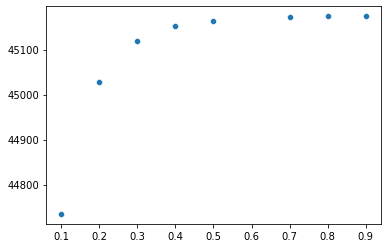

In [126]:
scatter = sns.scatterplot(x=list_max_df, y=list_max_voc_lenght)

## What we observe is that the number of words decrease strongly as we increase ```min_df```, meaning that there is a lot of not common words that are removed by increasing the threshold.
## On the otherside, there is very few words that are removed when reducing ```max_df``` with a plateau with ```max_df > 0.5```. Meaning that there is not a lot of very common words in the reviews.

## We take the vectorizer with min_df=0.10 which leave use with roughly 400 words.

In [127]:
review_text = df_data['Review']
count_vect = joblib.load('models/min_df/TfIdfVectorizer_0.10_min_df.joblib')
raw_data_stemmed = count_vect.transform(review_text)

In [128]:
print('Number of words in the vocuabulary: {}.'.format(len(count_vect.vocabulary_)))

Number of words in the vocuabulary: 438.


In [129]:
df_frequency = pd.DataFrame({'Vocabulary': count_vect.get_feature_names_out(), 'Inverse Document Frequency':count_vect.idf_})

### We take a quick look at the least common words. And even though some of them are not that meaningfull (Typical, ncf, stand, fair, wait), some could be good indicators (pie, ash, tannic)
### This indicate that the value of min_df is probably good enough, but a better job on the stopwords could help.

In [130]:
df_frequency.sort_values('Inverse Document Frequency', ascending=False)[:15]

,Vocabulary,Inverse Document Frequency
284,pie,3.300025
409,typical,3.297188
241,ncf,3.297188
132,filtration,3.295301
365,stand,3.292478
322,round,3.292478
417,wait,3.290600
386,tannic,3.289662
327,sauce,3.289662
13,ash,3.289662


In [139]:
df_words = pd.DataFrame.sparse.from_spmatrix(raw_data_stemmed, columns=count_vect.get_feature_names_out())

In [132]:
df_data.reset_index(inplace=True, drop=True)
df = pd.concat([df_data, df_words.sparse.to_dense()], axis=1)

In [133]:
joblib.dump(df_frequency, 'dataset/words_frequency.joblib')
joblib.dump(df_words, 'dataset/df_words.joblib')
joblib.dump(df, 'dataset/cleaned_dataset.joblib');

## Extra. Save the dataset into a MYSQL DB

### In the future, I would like to create a webapp using Django, or Dask. And having the data saved in a SQL DB will probably help for that

In [47]:
import sqlite3
import joblib

In [48]:
db = sqlite3.connect('dataset/whiskey_database.db')

In [49]:
df_words = joblib.load('dataset/df_words.joblib')
df = joblib.load('dataset/cleaned_dataset.joblib')

In [50]:
type_col = []
for col in df.columns:
    if 'Type_' in col:
        type_col.append(col)

name_col = []
for col in df.columns:
    if 'Username_' in col:
        name_col.append(col)

df_type = df[type_col]
df_name = df[name_col]

rename_type = {type: type.split('_')[1] for type in type_col}
rename_name = {name: name.split('_')[1] for name in name_col}

df_type = df_type.rename(columns=rename_type)
df_name = df_name.rename(columns=rename_name)

In [51]:
df[['Whiskey Name', 'Score']].to_sql('whiskeys', db, index_label='id', dtype={'Whiskey Name': 'String', 'Score': 'Integer'}, if_exists='replace')
df['Review'].to_sql('review', db, index_label='id', dtype= 'String', if_exists='replace')
df_words.sparse.to_dense().to_sql('words', db, index_label='id', dtype='Float', if_exists='replace')
df_type.to_sql('type', db, index_label='id', dtype='Boolean', if_exists='replace')
df_name.to_sql('name', db, index_label='id', dtype='Boolean', if_exists='replace')

C:\Users\loic\anaconda3\envs\EPFL_ML_updated\lib\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(
